# Part 1: Neural Networks Basics

## Introduction

In this part, you'll implement a simple neural network for EMNIST character recognition. This will help you understand the fundamentals of neural networks, including dense layers, activation functions, and dropout.

## Learning Objectives

- Load and preprocess EMNIST dataset
- Implement a simple neural network with dense layers
- Train and evaluate the model
- Save model and metrics in the correct format

## Setup and Installation

In [38]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow import keras
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_1', exist_ok=True)
os.makedirs('logs', exist_ok=True)
print('tf version:', tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("List of physical devices: ", tf.config.list_physical_devices())

tf version: 2.19.0
Num GPUs Available:  1
List of physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Data Loading and Preprocessing

In [25]:
# Load EMNIST dataset
# import tensorflow_datasets as tfds
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data('letters')
import tensorflow_datasets as tfds
(train, test), dataset_info = tfds.load(
  'emnist/letters',
  split=['train', 'test'],
  as_supervised=True,
  with_info=True,
)
def preprocess_images(image, label):
    # Convert to float and normalize to [0, 1]
    # This is important because neural networks work better with normalized data
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.flip_left_right(image)
    image = tf.image.rot90(image)
    return image, label
train = train.map(preprocess_images)
test = test.map(preprocess_images)
x_train = []
y_train = []
for image, label in tfds.as_numpy(train.take(20000)):
    x_train.append(image)
    y_train.append(label)
x_train = np.array(x_train)
y_train = np.array(y_train)
print(f'y_train shape: {y_train.shape}')

x_test = []
y_test = []
for image, label in tfds.as_numpy(test.take(2000)):
    x_test.append(image)
    y_test.append(label)
x_test = np.array(x_test)
y_test = np.array(y_test)
# temp = x_train[0].T
# display(temp)
# display(temp.shape)

2025-05-15 18:03:24.571473: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


y_train shape: (20000,)


2025-05-15 18:03:24.962744: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-15 18:03:24.964362: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
print(f"dataset info: {dataset_info}")

dataset info: tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/letters/3.1.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST Letters
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='/Users/macbook/tensorflow_datasets/emnist/letters/3.1.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=44.14 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
    

Training data shape: (20000, 28, 28, 1)
Test data shape: (2000, 28, 28, 1)
Number of classes: 26


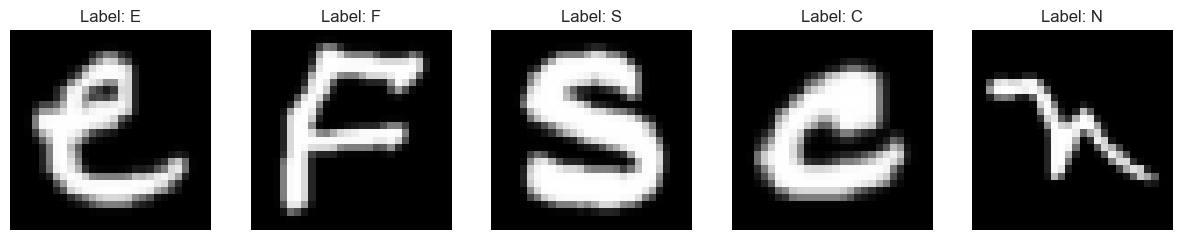

In [27]:
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    k =np.random.randint(0, len(x_test) - 1)
    plt.imshow(x_test[k], cmap='gray')
    plt.title(f'Label: {chr(y_test[k]-1 + (ord('A') if y_test[k] < 26 else ord('0') - 26))}')
    plt.axis('off')
plt.show()

In [28]:
# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=62)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=62)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')


Preprocessed training data shape: (16000, 28, 28, 1)
Preprocessed validation data shape: (4000, 28, 28, 1)
Preprocessed test data shape: (2000, 28, 28, 1)
y_train shape: (16000, 62)
y_val shape: (4000, 62)
y_test shape: (2000, 62)


In [19]:
print(y_train.sum().sum(),y_test.sum().sum(),y_val.sum().sum())

16000.0 2000.0 4000.0


## 2. Model Implementation

In [33]:
# Create simple neural network
def create_simple_nn(input_shape, num_classes):
    """
    Create a simple neural network for EMNIST classification.
    
    Requirements:
    - Must use at least 2 dense layers
    - Must include dropout layers
    - Must use categorical crossentropy loss
    
    Goals:
    - Achieve > 80% accuracy on test set
    - Minimize overfitting using dropout
    - Train efficiently with appropriate batch size
    
    Args:
        input_shape: Shape of input data (should be (784,) for flattened 28x28 images)
        num_classes: Number of output classes (26 for letters)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.MaxPooling2D((2, 2)),
        # tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax'),
    ])
    
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and compile model
model = create_simple_nn(input_shape=(28,28,1), num_classes=62)
model.summary()

/Users/macbook/Documents/ucsf_couses/ds223/assignments/6-neural-nets-Exynos-8890/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 62)             │        31,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,468,990 (13.23 MB)

 Trainable params: 3,467,326 (13.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

## 3. Training and Evaluation

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.4317 - loss: 2.4919 - val_accuracy: 0.0480 - val_loss: 6.4254 - learning_rate: 1.0000e-04
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.7662 - loss: 0.8048 - val_accuracy: 0.0388 - val_loss: 6.4359 - learning_rate: 1.0000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.8176 - loss: 0.5919 - val_accuracy: 0.1315 - val_loss: 4.1493 - learning_rate: 1.0000e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8508 - loss: 0.4713 - val_accuracy: 0.5238 - val_loss: 1.6714 - learning_rate: 1.0000e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.8656 - loss: 0.4203 - val_accuracy: 0.8140 - val_loss: 0.6326 - learning_rate: 1.0000e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.8841 - loss: 0.3701 - val_accuracy: 0.8783 - val_loss: 0.3966 - learning_rate: 1.0000e-04
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/ste

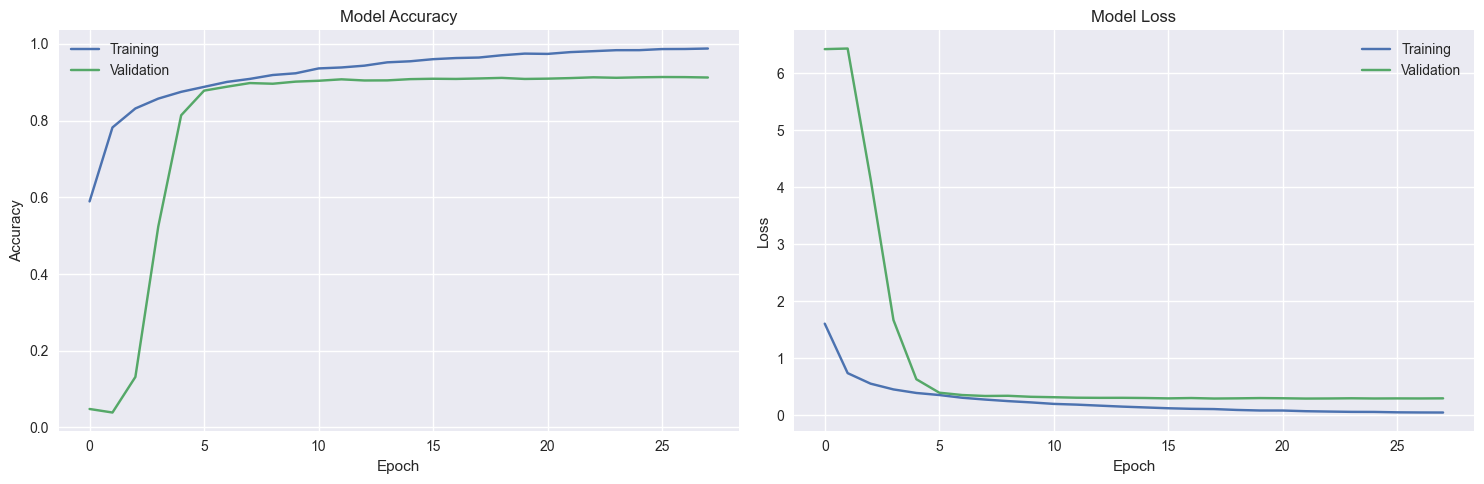

In [34]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=0.001,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/emnist_classifier.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9000 - loss: 0.3209
Test accuracy: 0.9010
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/Users/macbook/Documents/ucsf_couses/ds223/assignments/6-neural-nets-Exynos-8890/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


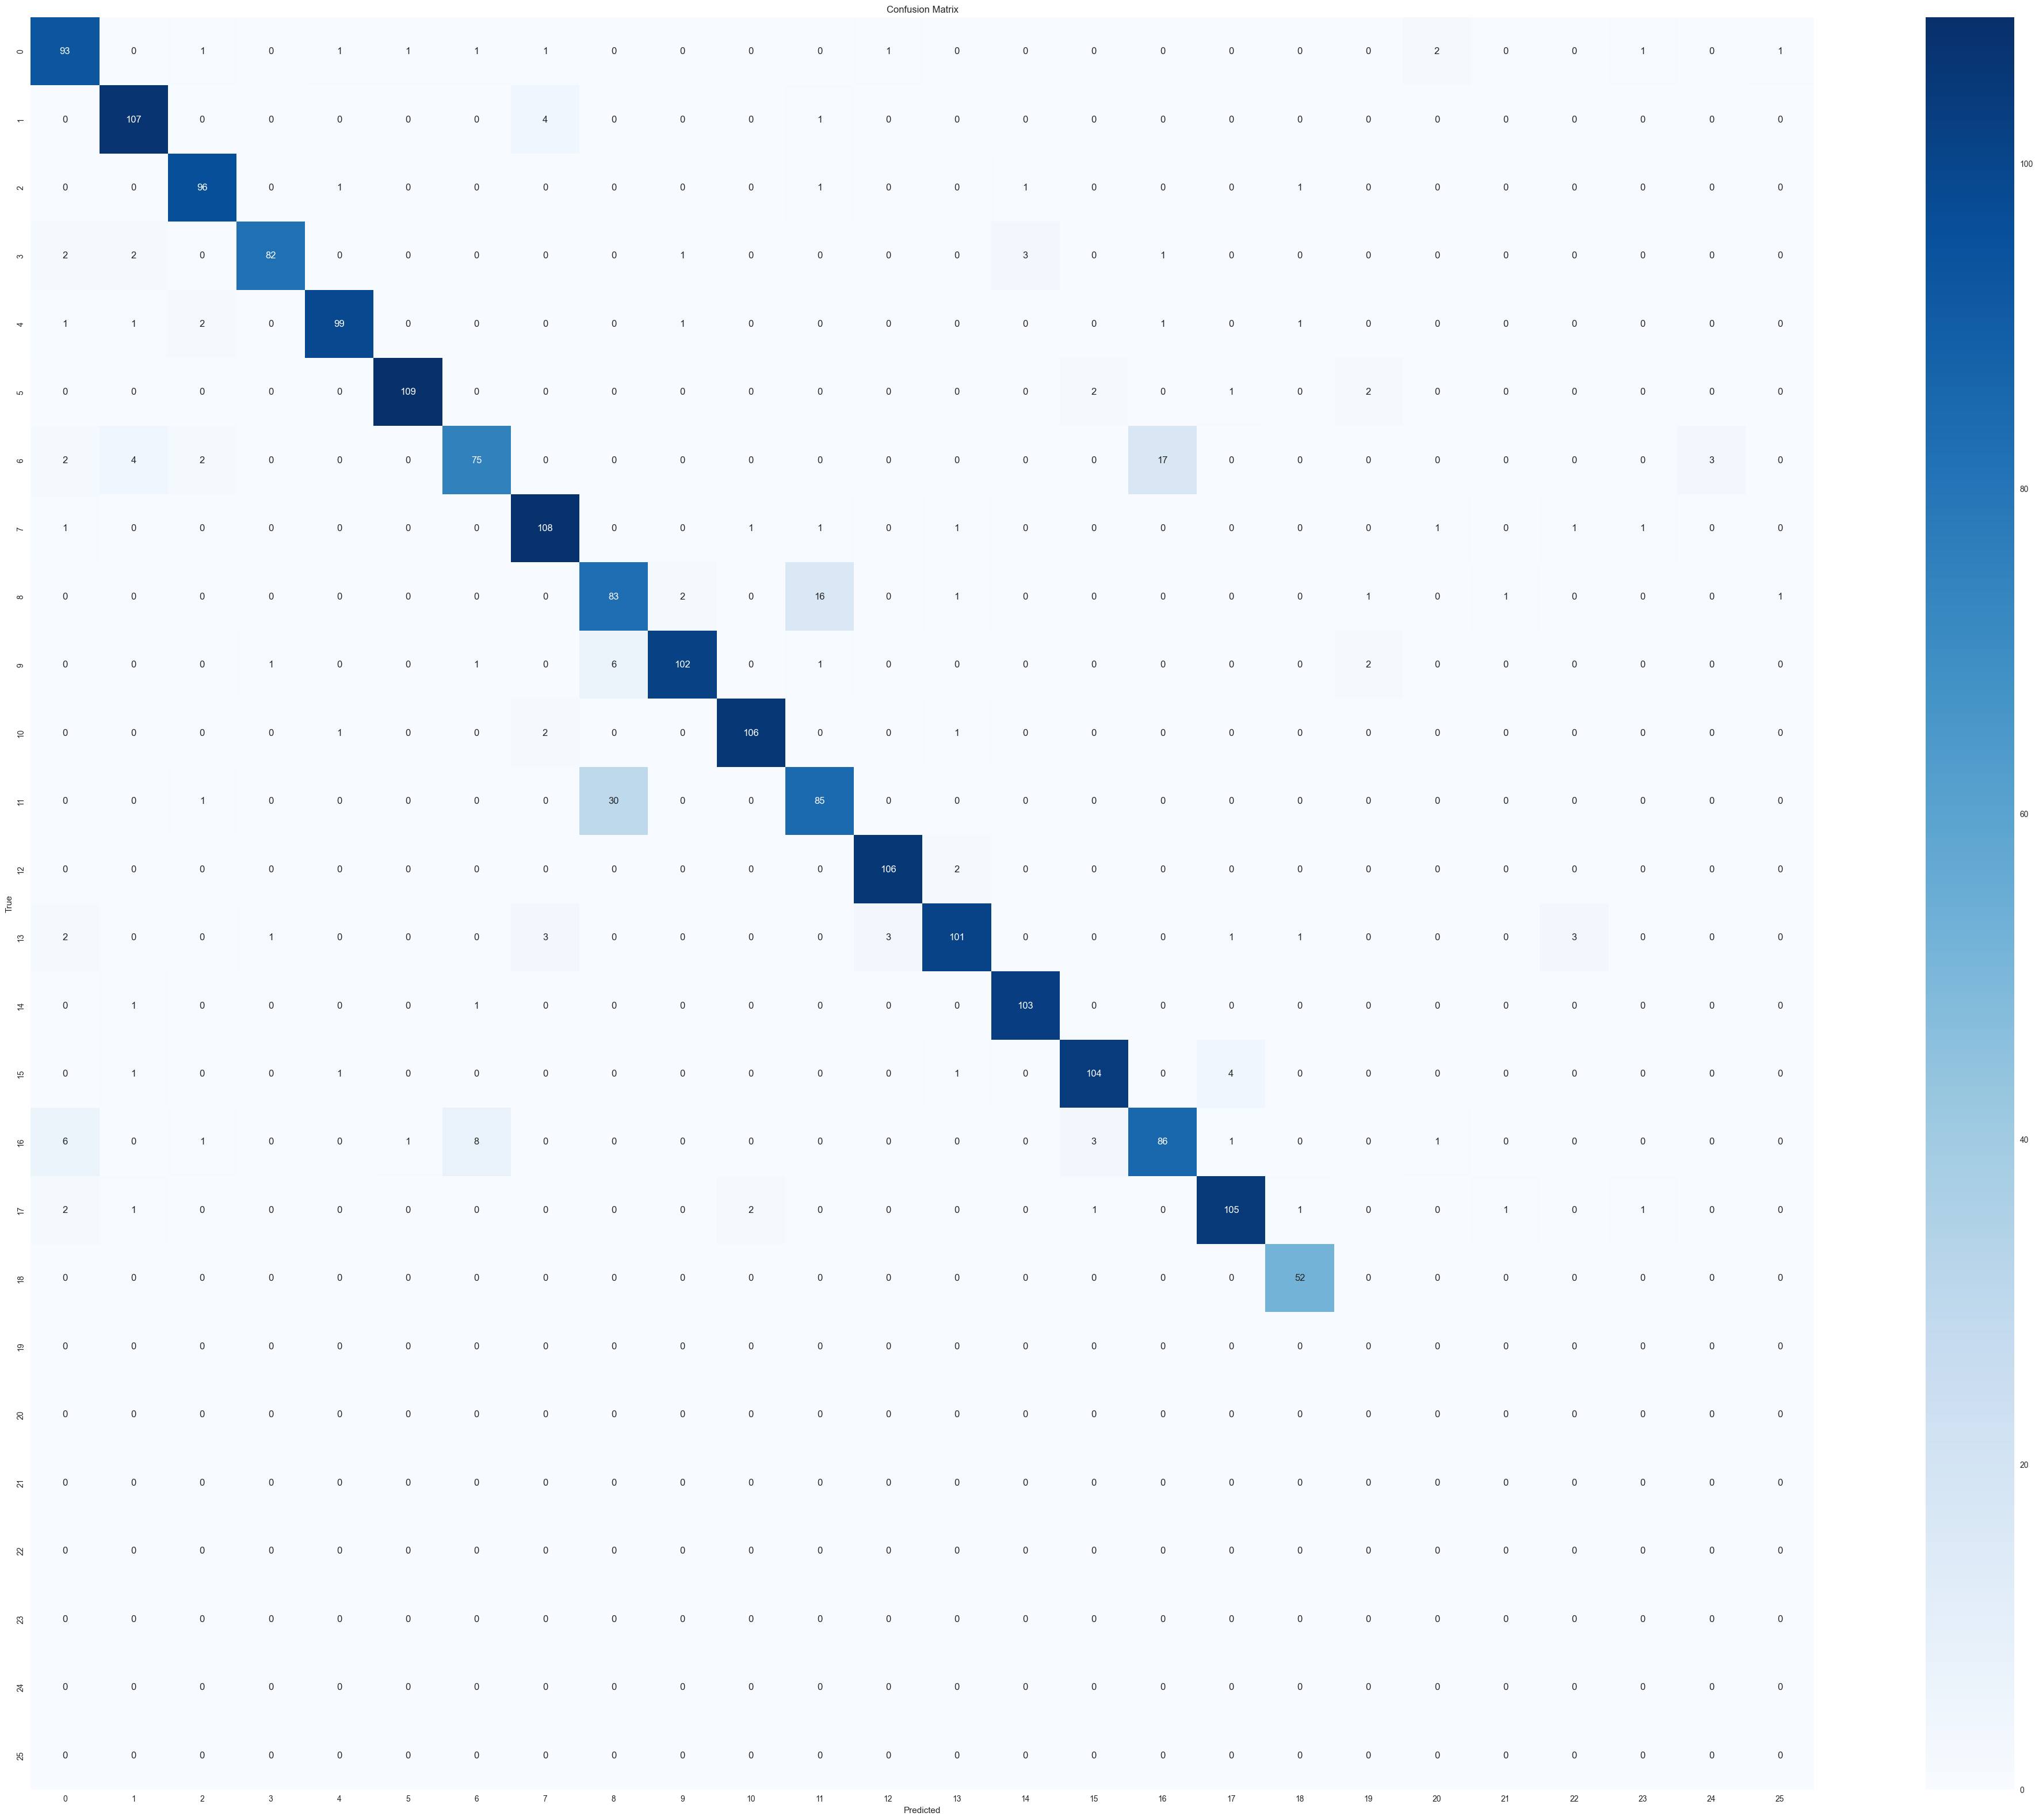

In [40]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(50, 40))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
# x,y 坐标都是数字或者字母，
plt.ylabel('True')
plt.show()

# Save metrics
metrics = {
    'model': 'emnist_classifier',
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# Save to file
with open('results/part_1/emnist_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")

## Progress Checkpoints

1. **Data Loading**:
   - [ ] Successfully load EMNIST dataset
   - [ ] Verify data shapes and ranges
   - [ ] Visualize sample images

2. **Preprocessing**:
   - [ ] Normalize pixel values
   - [ ] Reshape data for dense layers
   - [ ] Convert labels to one-hot encoding

3. **Model Implementation**:
   - [ ] Create model with required layers
   - [ ] Verify architecture requirements
   - [ ] Test model with sample input

4. **Training**:
   - [ ] Train model with callbacks
   - [ ] Monitor training progress
   - [ ] Save best model

5. **Evaluation**:
   - [ ] Calculate performance metrics
   - [ ] Save metrics in correct format
   - [ ] Visualize results

## Common Issues and Solutions

1. **Data Loading Issues**:
   - Problem: EMNIST dataset not found
   - Solution: Check internet connection and TensorFlow installation

2. **Preprocessing Issues**:
   - Problem: Shape mismatch in dense layers
   - Solution: Ensure data is properly reshaped to (n_samples, 784)
   - Problem: Label encoding errors
   - Solution: Verify label range and one-hot encoding

3. **Model Issues**:
   - Problem: Training instability
   - Solution: Add batch normalization, reduce learning rate
   - Problem: Overfitting
   - Solution: Increase dropout, use data augmentation

4. **Evaluation Issues**:
   - Problem: Metrics format incorrect
   - Solution: Follow the exact format specified
   - Problem: Performance below threshold
   - Solution: Adjust architecture, hyperparameters